In [1]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
# import torch
# from core import weights

read icdata
read uptdata
read eadata
read mspdata


In [2]:
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)

In [3]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(1e5))

In [4]:
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1

In [5]:
gamma_arr = [-2, -2.2, -2.53, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")


Number of energy bins:  100000

Number of phi bins:  1000

Calculating weights...




In [6]:
eareaa = [i.astype(np.float64) for i in earea]
eareaa = np.asfarray(eareaa, dtype=np.float64)
eareaa[0][0]
earea2 = np.asfortranarray(earea)
earea2 = earea2[0].astype(np.float64)

In [7]:
w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]

In [8]:
DEFAULT_PERM = np.arange(0, len(msdec), dtype=np.int64)

In [9]:
np.random.permutation( DEFAULT_PERM)

array([1758,  743,  752, ...,  799, 1997,  249])

Calculating wt_acc for all pulsars and seasons and gamma


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Calculated wt_acc for all pulsars and seasons and gamma

Calculating S_i for all neutrinos and gammas and weighting schemes...



100%|██████████| 4/4 [03:54<00:00, 58.71s/it]


Calculated S_i for all neutrinos and gammas and weighting schemes
Loading all_Bi from pickle...
Loaded all_Bi from pickle

Calculating ns_HAT for all gamma and weighting schemes...



100%|██████████| 10/10 [00:12<00:00,  1.22s/it]



Calculationed ns_HAT for all gamma and weighting schemes

CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:09<00:00, 103.83it/s]


gamma = 1


100%|██████████| 1000/1000 [00:09<00:00, 105.24it/s]


gamma = 2


100%|██████████| 1000/1000 [00:09<00:00, 106.17it/s]


gamma = 3


100%|██████████| 1000/1000 [00:09<00:00, 101.25it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 130.45it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 128.14it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 128.47it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 124.12it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 132.89it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 129.91it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 130.22it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 124.84it/s]


ws = 3
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 132.31it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 129.69it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 130.51it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 126.15it/s]



CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS
-4853063.132552406 26.294844135863592
-8252320.18847002 28.44738739503626
-6829177.322729414 26.11708543494838
-7216919.723852731 22.08303014223037
wt

-6121732.795072436 -1.4241718916039187e-11
-8826153.340747524 -6.485123549433211e-11
-6424720.144560432 -1.697264551184315e-10
-5904694.682231533 -1.0087299885939382e-09
wt

-11658228.067020886 0.2850723660268249
-6353119.110798572 1.089721121186402
-7596889.923197842 1.7723055449683771
-10552023.78201557 1.836634252786366
wt

5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25
5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25
5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25

TS_vs_E2dfde_all_w_model_bins=100000.png
DONE


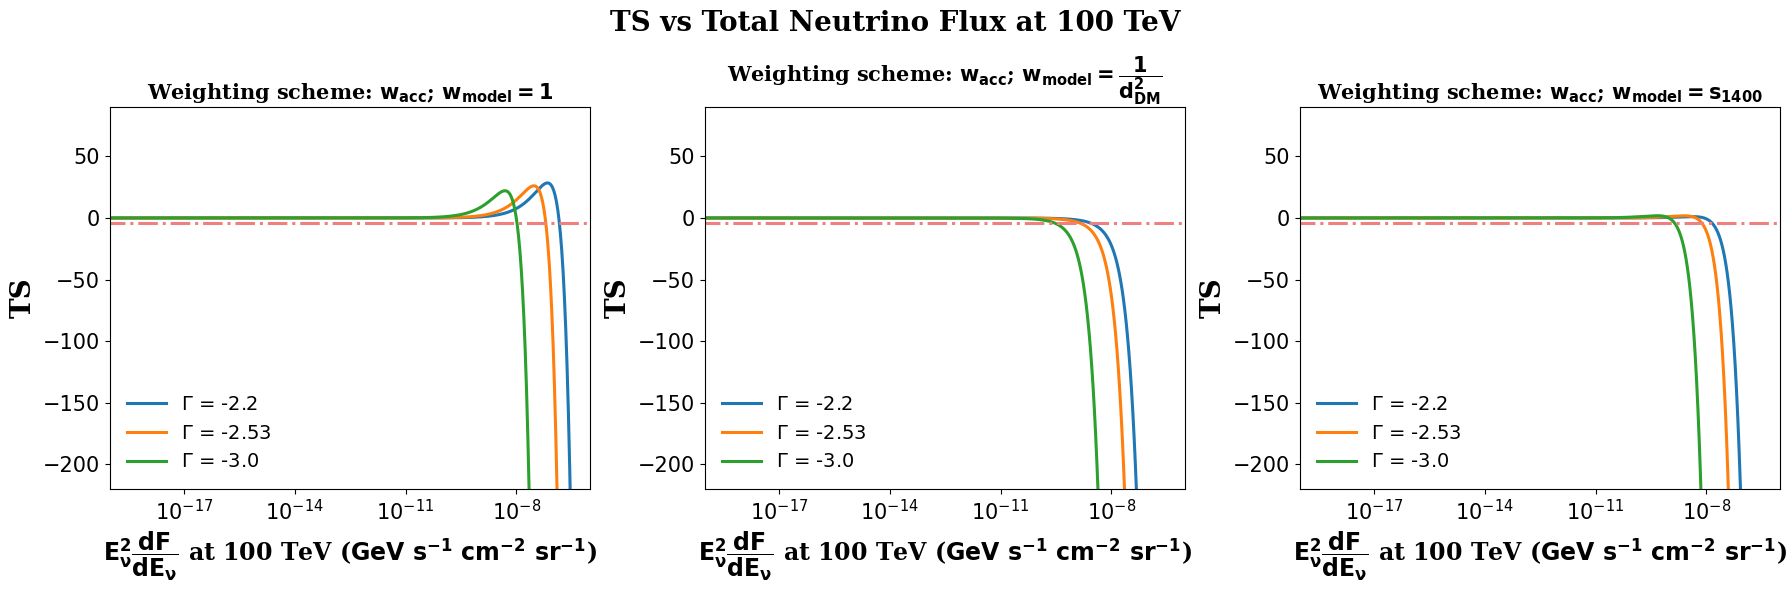

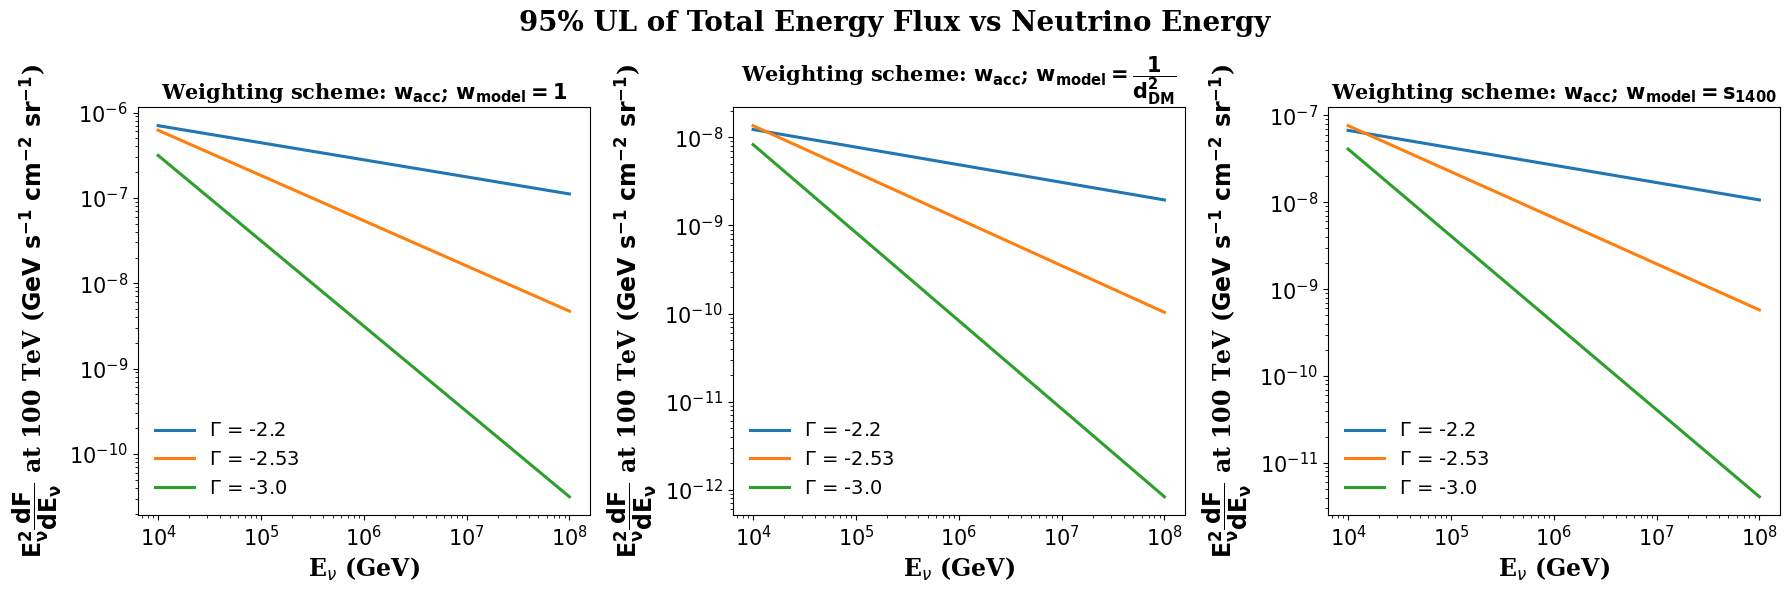

Calculating wt_acc for all pulsars and seasons and gamma


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Calculated wt_acc for all pulsars and seasons and gamma

Calculating S_i for all neutrinos and gammas and weighting schemes...



100%|██████████| 4/4 [03:59<00:00, 59.90s/it]


Calculated S_i for all neutrinos and gammas and weighting schemes
Loading all_Bi from pickle...
Loaded all_Bi from pickle
Loading ns_hat from pickle...
Loaded ns_hat from pickle with nbins = 100000

CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:10<00:00, 99.20it/s]


gamma = 1


100%|██████████| 1000/1000 [00:09<00:00, 106.61it/s]


gamma = 2


100%|██████████| 1000/1000 [00:09<00:00, 108.50it/s]


gamma = 3


100%|██████████| 1000/1000 [00:09<00:00, 102.81it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 131.23it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 132.06it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 129.27it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 128.98it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 131.11it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 132.71it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 133.31it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 130.40it/s]


ws = 3
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 134.76it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 132.50it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 132.48it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 128.62it/s]



CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS
-4830328.1729030665 18.15468241532823
-8204800.618844744 18.521260285450733
-6787982.375582497 15.20018036275343
-7172246.423417393 11.213455050464265
wt

-6187758.722594213 5.991229734449582e-11
-8924595.256722143 6.641642790799591e-11
-6513133.853263444 -5.4314330893789e-12
-5995123.953273482 -2.8071456307784647e-10
wt

-11824169.730118591 1.2048473322918018e-10
-6473918.265347608 0.028738941021369806
-7689420.292083033 0.13884326378039966
-10616212.373064678 0.15629487791387858
wt

5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25
5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25
5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25

TS_vs_E2dfde_all_w_model_bins=100000.png
DONE


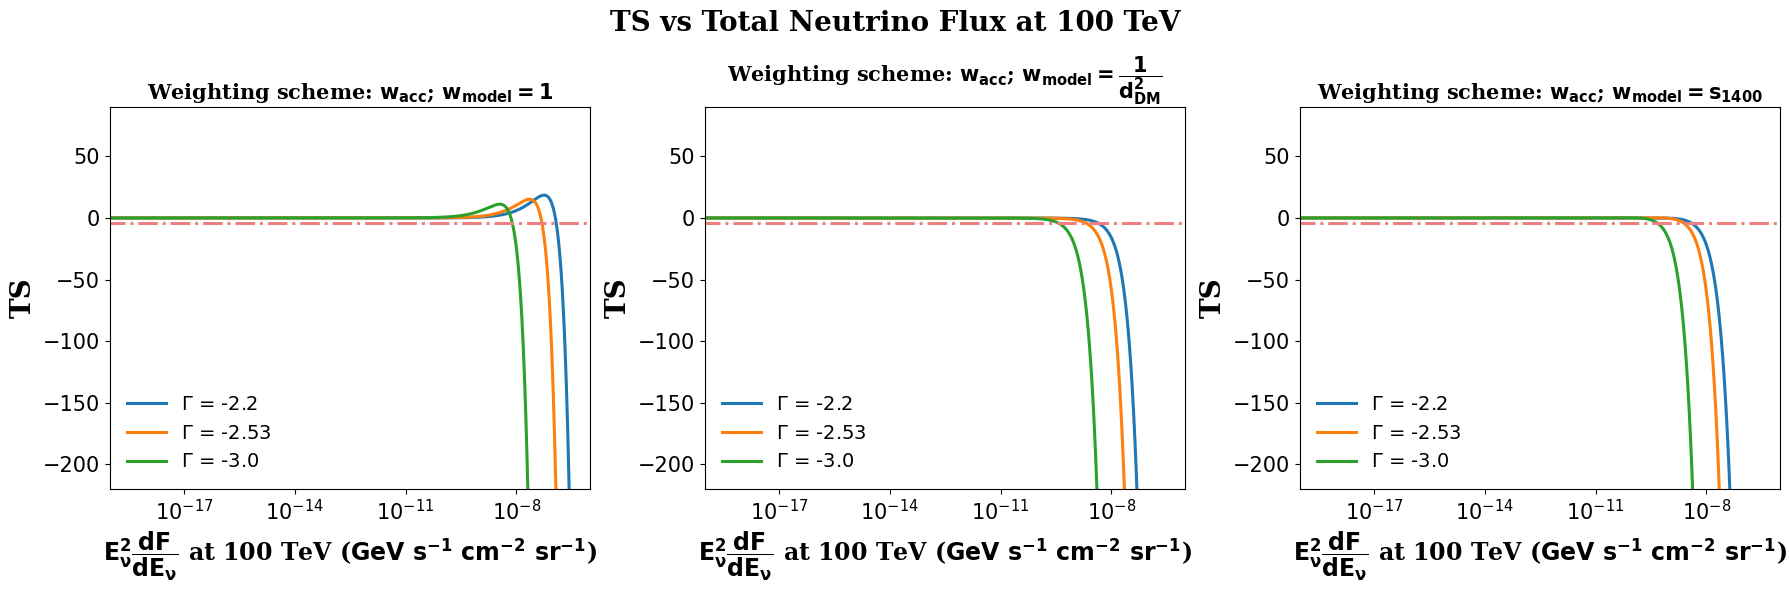

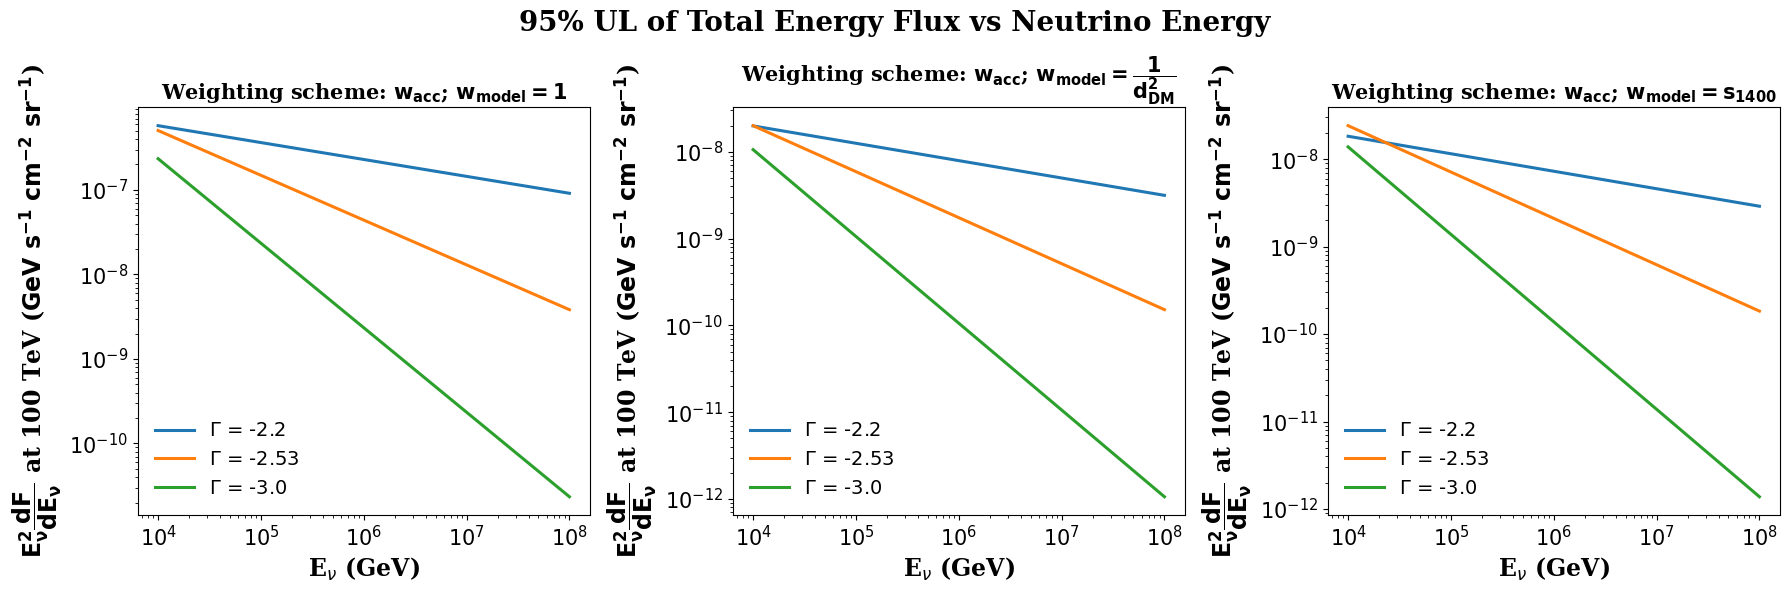

In [10]:
for perm in range(2):
    prm = np.random.permutation( DEFAULT_PERM)
    msdec = msdec[prm]

    msdec_bin_indices = np.zeros(p, dtype=np.int64)
    for i in prange(p):
        msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1

    @vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
    def psr_wt_sing_gamma(psrno,gamma, season):

        tt_upt = t_upt[season]
        l = msdec_bin_indices[psrno]
        wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
        for i in prange(len(enus)):
            wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


        return np.trapz(wt_ac_temp, enus)

    altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
    if f'wt_acc_{len(enus)}_bins_perm_{perm}.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
        print("Loading wt_acc from pickle")
        # try:
        #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
        # except:
        with open(altier_path[0] + f'wt_acc_{len(enus)}_bins_perm_{perm}.pkl', 'rb') as f:
            wt_acc = pickle.load(f)
        
        
        print("Loaded wt_acc from pickle with nbins= ", len(enus))

    else:
        print("Calculating wt_acc for all pulsars and seasons and gamma")
        wt_acc = []
        for gamma in prange(len(gamma_arr)):
            wt_allpsr = []
            for season in tqdm(prange(10)):
                # tmp = []
                # for psrno in prange(p):
                    # w_model = w_models[psrno]
                    # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                    # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

                wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
                # tmp = []
            wt_acc.append(wt_allpsr)
            wt_allpsr = []
            
        wt_acc = np.asfarray(wt_acc, dtype=np.float64)
        with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
            pickle.dump(wt_acc, f)
        print("Calculated wt_acc for all pulsars and seasons and gamma")
    season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
    season_widts= np.diff(season_walls)
    


    #Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

    @njit(nogil=True)
    def S_ijk(nu): 

        '''
        Calculates S_ij as in EQN 7 of 2205.15963
        ----------

        Parameters
        ----------
        nu : int
            Index of the neutrino in the sample
            
        
        Returns
        -------
            Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
        '''
        ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
        sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
        return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


    @njit(nogil=True)
    def S_ik(nu, weight, w_models, gamma_index, ws):

        '''
        
        Calculates S_i as in EQN 8 of 2205.15963
        ----------

        Parameters
        ----------
        nu : int
            Index of the neutrino in the sample

        normalized_wt : array
            Normalized weights of the pulsars


        gamma_index : int
            Index of the gamma value in the gamma array

        ws : int
            Index of the weight model

        Returns
        -------
            Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

        '''

        sij = S_ijk(nu)
        season = 0
        for i in range(10):
            if season_walls[i] <= nu and nu < season_walls[i+1]:
                season = i
                break

        return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2

    @njit(parallel=True, nogil=True)
    def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
        '''
        Calculates S_i as in EQN 8 of 2205.15963
        ----------

        Parameters
        ----------
        weight : array
            weights of the pulsars

        season : int
            Season of the neutrino

        gamma_index : int
            Index of the gamma value in the gamma array

        ws : int
            Index of the weight model

        Returns
        -------
            Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
        '''



        tmp = []
        if ws == -1: #No weights
            for nu in prange(len(icra)):
                tmp.append(np.sum(S_ijk(nu)))
            return np.array(tmp, dtype=np.float64)

        for nu in prange(len(icra)):
            tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
        return np.array(tmp, dtype=np.float64)
    #Pickle
    if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_perm_{perm}.pkl'):
        print("Loading all_Si_ws_g_s from pickle")
        with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_perm_{perm}.pkl', 'rb') as f:
            all_Si_ws_g_s = pickle.load(f)
        print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
    else:


        print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

        all_Si_ws_g_s = []
        tmp = []
        tmp_wt_acc = []
        tmp_wt_acc_w_dist = []
        tmp_wt_acc_w_s1400 = []

        for gamma_index in tqdm(prange(4)):
            # for season in tqdm(prange(10)):
            tmp.append(Sik_sing_s_g(gamma_index, -1))
            tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
            tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
            tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


        all_Si_ws_g_s.append([tmp, tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
        tmp = []
        tmp_wt_acc = []
        tmp_wt_acc_w_dist = []
        tmp_wt_acc_w_s1400 = []
        all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

        print("Calculated S_i for all neutrinos and gammas and weighting schemes")
        #Save to pickle
        with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_perm_{perm}.pkl', 'wb') as f:
            pickle.dump(all_Si_ws_g_s, f)


    # @jit(nopython=True)
    @vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
    def Bi_stacked_compute(nu, cone=5):

        '''
        Calculates B_i as in EQN 9 of 2205.15963
        ----------

        Parameters
        ----------
        nu : int
            Index of the neutrino from IceCube sample
        cone : float
            Cone angle in degrees.
        

        Returns
        -------
        float
            Returns the background PDF for the {nu}th neutrino
        '''

        # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
        count=0
        for i in prange(len(icdec)):
            if abs(icdec[i] - icdec[nu]) <= cone:
                count+=1
        binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
        return count/(binwidth * N_ic)           #No units or sr**-1
    #Pickle
    if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
        print("Loading all_Bi from pickle...")
        with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
            all_Bi = pickle.load(f)
        print("Loaded all_Bi from pickle")
    else:
        print("\nCalculating Bi for all neutrinos\n")
        all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
        # all_Bi+=1e-90
        print("\nCalculated Bi for all neutrinos")
        #Save to pickle
        with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
            pickle.dump(all_Bi, f)
    type(msdec_bin_indices[0])
    arr = np.zeros(10, dtype=np.float64)

    @vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
    def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
    

        tt_upt = t_upt[season]

            
        l = msdec_bin_indices[psrno]


        ns_temp = np.zeros(len(enus), dtype=np.float64)
        for i in prange(len(enus)):
            ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)



        return np.trapz(ns_temp, enus)     #in s cm2 eV

    def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
        ns_hat = 0
        ns_hat_wt = 0
        ns_hat_wt_dist = 0
        ns_hat_wt_s1400 = 0
        for season in tqdm(prange(10)):
            # for psr in prange(p):
                # wt = all_weights[0][gamma_arr.index(gamma)][psr][ea_season(season)]
            wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])

            wt = wt_acc[gamma_arr.index(gamma)][season]
            ns_hat = ns_singleseason_sing_psr_HAT(prange(p), gamma, phi0, season)

        

            ns_hat_wt += np.dot((wt/wt_sum),  ns_hat)
            ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
            ns_hat_wt_s1400 += np.dot(wt * w_models[2]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[2])), ns_hat)
        return np.array([np.sum(ns_hat), ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)
    #Pickle
    arr = []
    if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl'):
        print("Loading ns_hat from pickle...")
        with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'rb') as f:
            arr = pickle.load(f)
        print("Loaded ns_hat from pickle with nbins =", len(enus))
    else:
        print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

        arr=[]
        for gamma in prange(len(gamma_arr)):
            tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
            np.savetxt('outputs/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
            arr.append(tmp)
            tmp = []

        arr = np.array(arr, dtype=np.float64)
        with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'wb') as f:
            pickle.dump(arr, f)
        print("\nCalculationed ns_HAT for all gamma and weighting schemes")
    @njit(parallel=True, nogil=True)
    def season_nu(nu):
        for i in prange(10):
            if nu >= season_walls[i] and nu < season_walls[i+1]:
                return i
    @jit(nopython=True)
    def Pr(x, Ns, S, B):
        nsN = x/Ns
        return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



    @njit(nogil=True)
    def TS_st_vec(x, S, B, Ns):
        nsN = x/Ns
        pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
        return np.sum(np.asfarray(2*np.log(pr/B)))

    lnu = 1134450
    Ns = lnu#np.count_nonzero(nuind+1)

    phio = np.logspace(-38, -20, 1000)
    print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

    all_TSS = []
    for ws in prange(4):
        tmpp = []
        print("ws = {}".format(ws))
        for gamma in prange(len(gamma_arr)):
            print("gamma = {}".format(gamma))
            # tmp = np.zeros(len(phio))
            # for season in tqdm(range(10)):
            t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
            @njit(nogil=True)
            def TS_for_all_psrs2(nsa):  
                return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
            temp = []
            for phi in tqdm(prange(len(phio))):
                temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
            tmpp.append(temp)
            temp = []
        all_TSS.append(tmpp)
        tmpp = []

    print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')
    ### $N \approx 10^6$
    all_TSS = np.array(all_TSS, dtype=np.float64)
    for w in range(1,4):
        for g in range(len(gamma_arr)):
            print(min(all_TSS[w][g]), max(all_TSS[w][g]))
            # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
            
        print('wt\n')

    with open(altier_path[0] + f'all_TSS_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_TSS, f)
    #Plotting

    all_TSS = np.asarray(all_TSS)
    gamma_arr = np.asarray(gamma_arr)

    all_e_UL = []
    e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
    for e_UL in e_decade:
        e2dfde = []

        for gamma in prange(len(gamma_arr)):
            temp = []
            for phi in range(len(phio)):
                temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
            e2dfde.append(temp)
        e2dfde = np.asarray(e2dfde)

        all_e_UL.append(e2dfde)
    mark = ['^', 'o', 's', 'd']
    for w in range(1, 4):
        for g in range(1, 4):
            print(phio[np.argmax(all_TSS[w][g])])
    all_UL = []
    for ws in range(1,4):
        ul_all_gamma = []
        for gamma in prange(len(gamma_arr)):
            temp = []
            for i in all_e_UL:
                dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
                temp.append(dist_g(-3.84))

            ul_all_gamma.append(temp)
        all_UL.append(ul_all_gamma)
    e2dfde = all_e_UL[1]

    font = {'family': 'serif',
            'weight': 'bold',
            'size': 22,
            'color':  'black',
            }
    smallerfont = {'family': 'serif',
            'color':  'black',
            'weight': 'bold',
            'size': 15,
            }

    axesfont = {'family': 'serif',
            'color':  'black',
            'weight': 'bold',
            'size': 17,
            }

    fig, axs = plt.subplots(1,3, figsize=(18, 6))

    for gamma in [ 1, 2, 3]:#range(4):
        
        for i in range(3):
            axs[i].plot(e2dfde[gamma]/1e9, all_TSS[i+1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2)# + ' with wt')    #in GeV

        

    axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
    axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
    axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


    for i in range(3):
        
        axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')
        axs[i].hlines(-3.84, 1e-20, 1e-5, linestyles='dashed', lw=2.2, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$', color='lightcoral')
        axs[i].set_xscale('log')
        axs[i].set_xlabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ $\mathsf{\mathbf{sr^{-1}}}$)', fontdict=axesfont)
        axs[i].set_ylabel('TS', fontdict=axesfont, fontsize=20)
        axs[i].xaxis.set_tick_params(labelsize=15)
        axs[i].yaxis.set_tick_params(labelsize=15)
        
        axs[i].set_ylim(-220, 90)
        axs[i].set_xlim(0.95e-19, 1e-6)

    plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=20, fontfamily='serif')

    plt.tight_layout()
    plt.savefig(f'outputs/TS_vs_E2dfde_all_w_model_bins={len(enus)}_perm_{perm}.png')
    # plt.show()
    print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}.png\nDONE')
    #SIMILAR PLOTS FOR 95% UPPER LIMIT 
    fig, axs = plt.subplots(1,3, figsize=(18, 6))



    for i in range(3):
        for gamma in range(1, len(gamma_arr)):

            axs[i].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[i][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-')# + ' with wt')    #in GeV

        
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        axs[i].set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
        axs[i].set_ylabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ $\mathsf{\mathbf{sr^{-1}}}$)', fontdict=axesfont)
        axs[i].xaxis.set_tick_params(labelsize=15)
        axs[i].yaxis.set_tick_params(labelsize=15)
        
        axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')


    axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
    axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
    axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


    plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
    plt.tight_layout()
    plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}_perm_{perm}.png')
    plt.show()


Calculating wt_acc for all pulsars and seasons and gamma


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Calculated wt_acc for all pulsars and seasons and gamma

Calculating S_i for all neutrinos and gammas and weighting schemes...



100%|██████████| 4/4 [03:57<00:00, 59.29s/it]


Calculated S_i for all neutrinos and gammas and weighting schemes
Loading all_Bi from pickle...
Loaded all_Bi from pickle
Loading ns_hat from pickle...
Loaded ns_hat from pickle with nbins = 100000

CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:09<00:00, 105.96it/s]


gamma = 1


100%|██████████| 1000/1000 [00:09<00:00, 107.49it/s]


gamma = 2


100%|██████████| 1000/1000 [00:09<00:00, 107.63it/s]


gamma = 3


100%|██████████| 1000/1000 [00:09<00:00, 104.37it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 130.31it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 129.57it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 129.64it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 127.53it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 132.01it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 131.48it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 132.10it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 129.62it/s]


ws = 3
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 132.98it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 130.71it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 131.40it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 128.35it/s]



CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS
-4803045.915835226 17.497870414879774
-8159628.792742532 19.95210350748876
-6750938.854708881 18.3703739761991
-7131019.439739388 15.056490430726072
wt

-6123291.726634353 1.4472305352797066
-8839192.833889492 1.8902886500959244
-6461300.969428053 1.8976481874391145
-5950786.104959835 1.6138566975689888
wt

-11567682.030495074 0.10056035728730493
-6322970.23020116 0.00028618687528832296
-7543420.317459703 4.986167033992096e-11
-10448538.312169936 -2.759947827371201e-10
wt

5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25
5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25
5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25

TS_vs_E2dfde_all_w_model_bins=100000.png
DONE


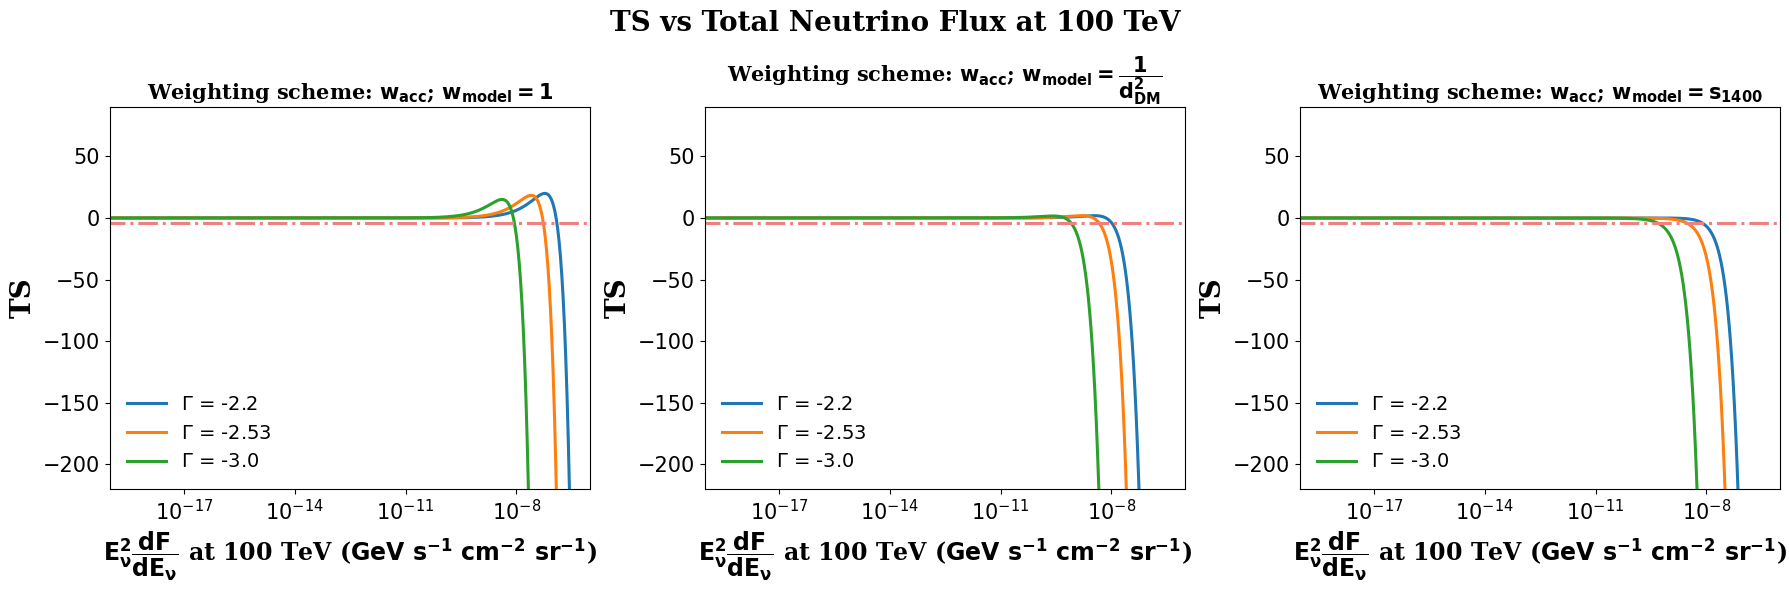

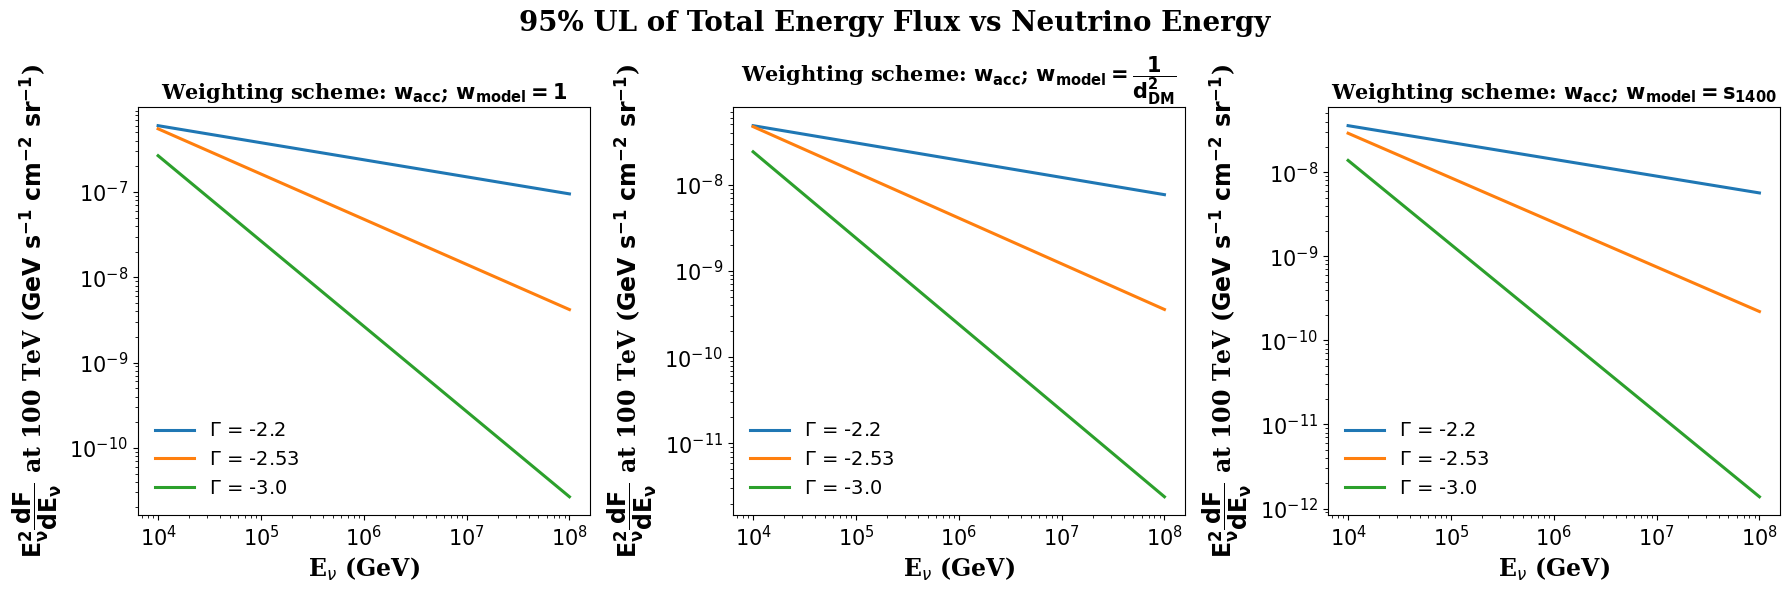

Calculating wt_acc for all pulsars and seasons and gamma


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Calculated wt_acc for all pulsars and seasons and gamma

Calculating S_i for all neutrinos and gammas and weighting schemes...



100%|██████████| 4/4 [03:55<00:00, 58.81s/it]


Calculated S_i for all neutrinos and gammas and weighting schemes
Loading all_Bi from pickle...
Loaded all_Bi from pickle
Loading ns_hat from pickle...
Loaded ns_hat from pickle with nbins = 100000

CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:09<00:00, 101.82it/s]


gamma = 1


100%|██████████| 1000/1000 [00:09<00:00, 103.66it/s]


gamma = 2


100%|██████████| 1000/1000 [00:09<00:00, 103.19it/s]


gamma = 3


100%|██████████| 1000/1000 [00:10<00:00, 99.18it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:08<00:00, 124.45it/s]


gamma = 1


100%|██████████| 1000/1000 [00:08<00:00, 123.92it/s]


gamma = 2


100%|██████████| 1000/1000 [00:08<00:00, 123.80it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 119.84it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 126.25it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 125.35it/s]


gamma = 2


100%|██████████| 1000/1000 [00:08<00:00, 123.27it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 122.48it/s]


ws = 3
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 126.27it/s]


gamma = 1


100%|██████████| 1000/1000 [00:08<00:00, 124.57it/s]


gamma = 2


100%|██████████| 1000/1000 [00:08<00:00, 123.96it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 119.33it/s]



CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS
-4768339.301842895 14.705261185086373
-8109840.552588623 16.743496228128905
-6705988.336590896 15.17921632799248
-7081594.369794843 12.224985782153366
wt

-5956636.658712566 5.2573501107340395e-11
-8585818.264723225 1.1212986094882572e-10
-6238162.592472052 0.2146871673864868
-5740913.164833756 0.426806624976055
wt

-11589895.108992014 -1.0124368010797109e-10
-6311336.466521142 -2.0682344727398435e-11
-7489083.868039946 -2.8634650215154923e-11
-10352105.598300017 5.900857568944792e-11
wt

5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25
5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25
5.4794723369002926e-24
2.491130026067796e-24
4.546295469532408e-25

TS_vs_E2dfde_all_w_model_bins=100000.png
DONE


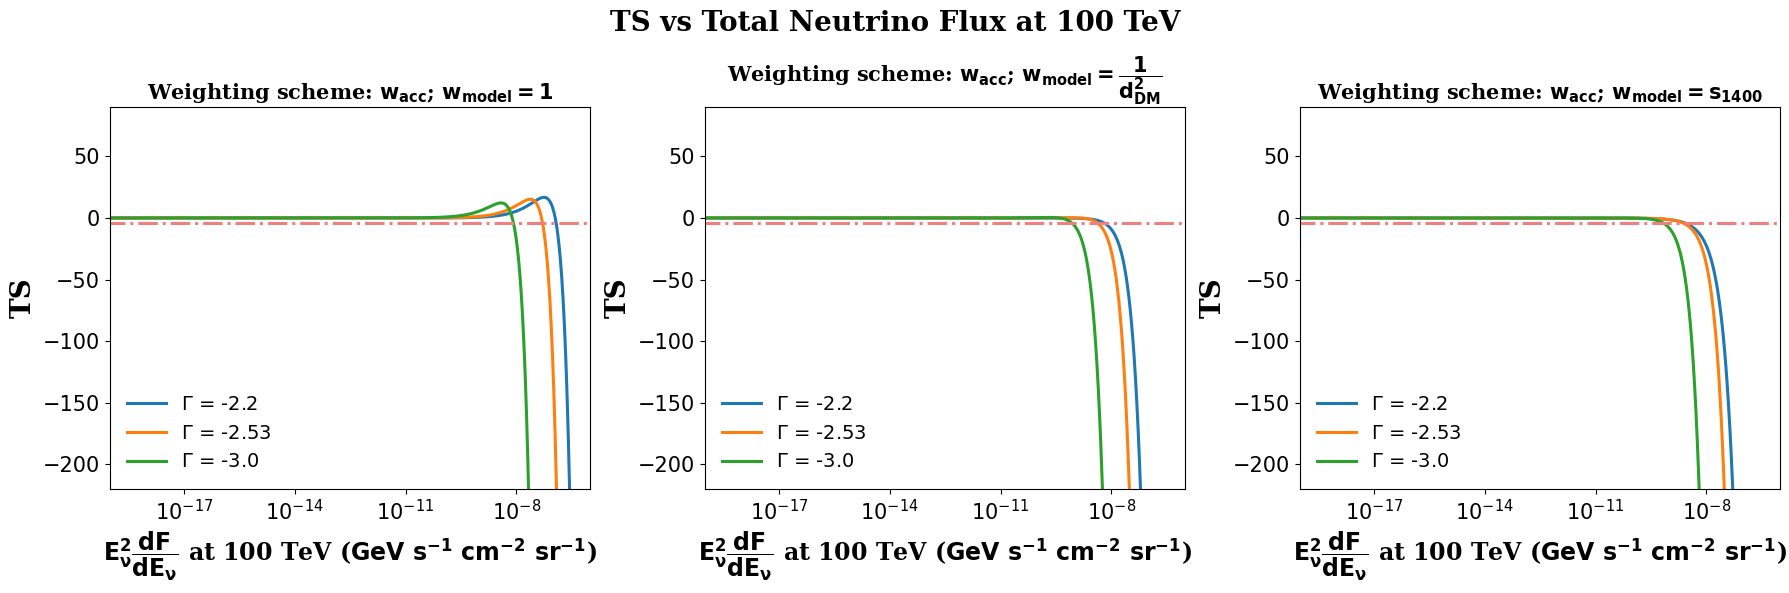

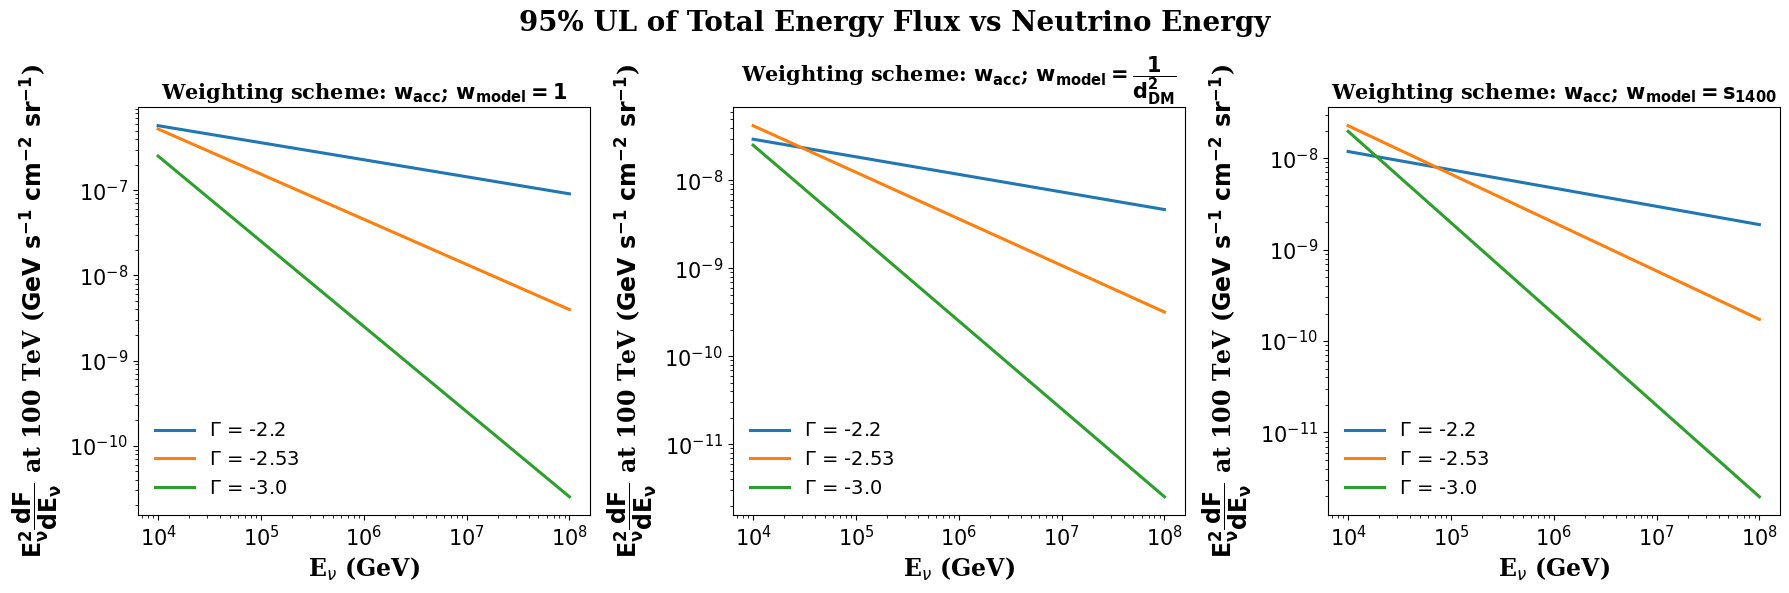

In [11]:
for perm in range(2):
    
    dec_offest = 2
    prm = np.random.permutation(DEFAULT_PERM)
    msdec = msdec[prm] + 2*np.random.uniform(size=len(msdec))

    msdec_bin_indices = np.zeros(p, dtype=np.int64)
    for i in prange(p):
        msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1

    @vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
    def psr_wt_sing_gamma(psrno,gamma, season):

        tt_upt = t_upt[season]
        l = msdec_bin_indices[psrno]
        wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
        for i in prange(len(enus)):
            wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


        return np.trapz(wt_ac_temp, enus)

    altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
    if f'wt_acc_{len(enus)}_bins_perm_{perm}_dec_off_{dec_offest}.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
        print("Loading wt_acc from pickle")
        # try:
        #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
        # except:
        with open(altier_path[0] + f'wt_acc_{len(enus)}_bins_perm_{perm}_dec_off_{dec_offest}.pkl', 'rb') as f:
            wt_acc = pickle.load(f)
        
        
        print("Loaded wt_acc from pickle with nbins= ", len(enus))

    else:
        print("Calculating wt_acc for all pulsars and seasons and gamma")
        wt_acc = []
        for gamma in prange(len(gamma_arr)):
            wt_allpsr = []
            for season in tqdm(prange(10)):
                # tmp = []
                # for psrno in prange(p):
                    # w_model = w_models[psrno]
                    # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                    # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

                wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
                # tmp = []
            wt_acc.append(wt_allpsr)
            wt_allpsr = []
            
        wt_acc = np.asfarray(wt_acc, dtype=np.float64)
        with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
            pickle.dump(wt_acc, f)
        print("Calculated wt_acc for all pulsars and seasons and gamma")
    season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
    season_widts= np.diff(season_walls)
    


    #Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

    @njit(nogil=True)
    def S_ijk(nu): 

        '''
        Calculates S_ij as in EQN 7 of 2205.15963
        ----------

        Parameters
        ----------
        nu : int
            Index of the neutrino in the sample
            
        
        Returns
        -------
            Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
        '''
        ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
        sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
        return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


    @njit(nogil=True)
    def S_ik(nu, weight, w_models, gamma_index, ws):

        '''
        
        Calculates S_i as in EQN 8 of 2205.15963
        ----------

        Parameters
        ----------
        nu : int
            Index of the neutrino in the sample

        normalized_wt : array
            Normalized weights of the pulsars


        gamma_index : int
            Index of the gamma value in the gamma array

        ws : int
            Index of the weight model

        Returns
        -------
            Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

        '''

        sij = S_ijk(nu)
        season = 0
        for i in range(10):
            if season_walls[i] <= nu and nu < season_walls[i+1]:
                season = i
                break

        return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2

    @njit(parallel=True, nogil=True)
    def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
        '''
        Calculates S_i as in EQN 8 of 2205.15963
        ----------

        Parameters
        ----------
        weight : array
            weights of the pulsars

        season : int
            Season of the neutrino

        gamma_index : int
            Index of the gamma value in the gamma array

        ws : int
            Index of the weight model

        Returns
        -------
            Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
        '''



        tmp = []
        if ws == -1: #No weights
            for nu in prange(len(icra)):
                tmp.append(np.sum(S_ijk(nu)))
            return np.array(tmp, dtype=np.float64)

        for nu in prange(len(icra)):
            tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
        return np.array(tmp, dtype=np.float64)
    #Pickle
    if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_perm_{perm}_dec_off_{dec_offest}.pkl'):
        print("Loading all_Si_ws_g_s from pickle")
        with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_perm_{perm}_dec_off_{dec_offest}.pkl', 'rb') as f:
            all_Si_ws_g_s = pickle.load(f)
        print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
    else:


        print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

        all_Si_ws_g_s = []
        tmp = []
        tmp_wt_acc = []
        tmp_wt_acc_w_dist = []
        tmp_wt_acc_w_s1400 = []

        for gamma_index in tqdm(prange(4)):
            # for season in tqdm(prange(10)):
            tmp.append(Sik_sing_s_g(gamma_index, -1))
            tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
            tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
            tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


        all_Si_ws_g_s.append([tmp, tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
        tmp = []
        tmp_wt_acc = []
        tmp_wt_acc_w_dist = []
        tmp_wt_acc_w_s1400 = []
        all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

        print("Calculated S_i for all neutrinos and gammas and weighting schemes")
        #Save to pickle
        with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_perm_{perm}_dec_off_{dec_offest}.pkl', 'wb') as f:
            pickle.dump(all_Si_ws_g_s, f)


    # @jit(nopython=True)
    @vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
    def Bi_stacked_compute(nu, cone=5):

        '''
        Calculates B_i as in EQN 9 of 2205.15963
        ----------

        Parameters
        ----------
        nu : int
            Index of the neutrino from IceCube sample
        cone : float
            Cone angle in degrees.
        

        Returns
        -------
        float
            Returns the background PDF for the {nu}th neutrino
        '''

        # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
        count=0
        for i in prange(len(icdec)):
            if abs(icdec[i] - icdec[nu]) <= cone:
                count+=1
        binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
        return count/(binwidth * N_ic)           #No units or sr**-1
    #Pickle
    if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
        print("Loading all_Bi from pickle...")
        with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
            all_Bi = pickle.load(f)
        print("Loaded all_Bi from pickle")
    else:
        print("\nCalculating Bi for all neutrinos\n")
        all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
        # all_Bi+=1e-90
        print("\nCalculated Bi for all neutrinos")
        #Save to pickle
        with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
            pickle.dump(all_Bi, f)
    type(msdec_bin_indices[0])
    arr = np.zeros(10, dtype=np.float64)

    @vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
    def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
    

        tt_upt = t_upt[season]

            
        l = msdec_bin_indices[psrno]


        ns_temp = np.zeros(len(enus), dtype=np.float64)
        for i in prange(len(enus)):
            ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)



        return np.trapz(ns_temp, enus)     #in s cm2 eV

    def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
        ns_hat = 0
        ns_hat_wt = 0
        ns_hat_wt_dist = 0
        ns_hat_wt_s1400 = 0
        for season in tqdm(prange(10)):
            # for psr in prange(p):
                # wt = all_weights[0][gamma_arr.index(gamma)][psr][ea_season(season)]
            wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])

            wt = wt_acc[gamma_arr.index(gamma)][season]
            ns_hat = ns_singleseason_sing_psr_HAT(prange(p), gamma, phi0, season)

        

            ns_hat_wt += np.dot((wt/wt_sum),  ns_hat)
            ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
            ns_hat_wt_s1400 += np.dot(wt * w_models[2]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[2])), ns_hat)
        return np.array([np.sum(ns_hat), ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)
    #Pickle
    arr = []
    if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl'):
        print("Loading ns_hat from pickle...")
        with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'rb') as f:
            arr = pickle.load(f)
        print("Loaded ns_hat from pickle with nbins =", len(enus))
    else:
        print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

        arr=[]
        for gamma in prange(len(gamma_arr)):
            tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
            np.savetxt('outputs/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
            arr.append(tmp)
            tmp = []

        arr = np.array(arr, dtype=np.float64)
        with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'wb') as f:
            pickle.dump(arr, f)
        print("\nCalculationed ns_HAT for all gamma and weighting schemes")
    @njit(parallel=True, nogil=True)
    def season_nu(nu):
        for i in prange(10):
            if nu >= season_walls[i] and nu < season_walls[i+1]:
                return i
    @jit(nopython=True)
    def Pr(x, Ns, S, B):
        nsN = x/Ns
        return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



    @njit(nogil=True)
    def TS_st_vec(x, S, B, Ns):
        nsN = x/Ns
        pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
        return np.sum(np.asfarray(2*np.log(pr/B)))

    lnu = 1134450
    Ns = lnu#np.count_nonzero(nuind+1)

    phio = np.logspace(-38, -20, 1000)
    print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

    all_TSS = []
    for ws in prange(4):
        tmpp = []
        print("ws = {}".format(ws))
        for gamma in prange(len(gamma_arr)):
            print("gamma = {}".format(gamma))
            # tmp = np.zeros(len(phio))
            # for season in tqdm(range(10)):
            t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
            @njit(nogil=True)
            def TS_for_all_psrs2(nsa):  
                return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
            temp = []
            for phi in tqdm(prange(len(phio))):
                temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
            tmpp.append(temp)
            temp = []
        all_TSS.append(tmpp)
        tmpp = []

    print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')
    ### $N \approx 10^6$
    all_TSS = np.array(all_TSS, dtype=np.float64)
    for w in range(1,4):
        for g in range(len(gamma_arr)):
            print(min(all_TSS[w][g]), max(all_TSS[w][g]))
            # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
            
        print('wt\n')

    with open(altier_path[0] + f'all_TSS_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_TSS, f)
    #Plotting

    all_TSS = np.asarray(all_TSS)
    gamma_arr = np.asarray(gamma_arr)

    all_e_UL = []
    e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
    for e_UL in e_decade:
        e2dfde = []

        for gamma in prange(len(gamma_arr)):
            temp = []
            for phi in range(len(phio)):
                temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
            e2dfde.append(temp)
        e2dfde = np.asarray(e2dfde)

        all_e_UL.append(e2dfde)
    mark = ['^', 'o', 's', 'd']
    for w in range(1, 4):
        for g in range(1, 4):
            print(phio[np.argmax(all_TSS[w][g])])
    all_UL = []
    for ws in range(1,4):
        ul_all_gamma = []
        for gamma in prange(len(gamma_arr)):
            temp = []
            for i in all_e_UL:
                dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
                temp.append(dist_g(-3.84))

            ul_all_gamma.append(temp)
        all_UL.append(ul_all_gamma)
    e2dfde = all_e_UL[1]

    font = {'family': 'serif',
            'weight': 'bold',
            'size': 22,
            'color':  'black',
            }
    smallerfont = {'family': 'serif',
            'color':  'black',
            'weight': 'bold',
            'size': 15,
            }

    axesfont = {'family': 'serif',
            'color':  'black',
            'weight': 'bold',
            'size': 17,
            }

    fig, axs = plt.subplots(1,3, figsize=(18, 6))

    for gamma in [ 1, 2, 3]:#range(4):
        
        for i in range(3):
            axs[i].plot(e2dfde[gamma]/1e9, all_TSS[i+1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2)# + ' with wt')    #in GeV

        

    axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
    axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
    axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


    for i in range(3):
        
        axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')
        axs[i].hlines(-3.84, 1e-20, 1e-5, linestyles='dashed', lw=2.2, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$', color='lightcoral')
        axs[i].set_xscale('log')
        axs[i].set_xlabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ $\mathsf{\mathbf{sr^{-1}}}$)', fontdict=axesfont)
        axs[i].set_ylabel('TS', fontdict=axesfont, fontsize=20)
        axs[i].xaxis.set_tick_params(labelsize=15)
        axs[i].yaxis.set_tick_params(labelsize=15)
        
        axs[i].set_ylim(-220, 90)
        axs[i].set_xlim(0.95e-19, 1e-6)

    plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=20, fontfamily='serif')

    plt.tight_layout()
    plt.savefig(f'outputs/TS_vs_E2dfde_all_w_model_bins={len(enus)}_perm_{perm}_dec_off_{dec_offest}.png')
    # plt.show()
    print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}.png\nDONE')
    #SIMILAR PLOTS FOR 95% UPPER LIMIT 
    fig, axs = plt.subplots(1,3, figsize=(18, 6))



    for i in range(3):
        for gamma in range(1, len(gamma_arr)):

            axs[i].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[i][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-')# + ' with wt')    #in GeV

        
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        axs[i].set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
        axs[i].set_ylabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ $\mathsf{\mathbf{sr^{-1}}}$)', fontdict=axesfont)
        axs[i].xaxis.set_tick_params(labelsize=15)
        axs[i].yaxis.set_tick_params(labelsize=15)
        
        axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')


    axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
    axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
    axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


    plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
    plt.tight_layout()
    plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}_perm_{perm}_dec_off_{dec_offest}.png')
    plt.show()
